# ADMIN - REMOVE FROM FINAL LESSON

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)

## set text displays for sklearn
from sklearn import set_config
set_config(display='text')

from lp_styles import *
from lp_functions import  * 

## Using pd.set_option to display more columns
pd.set_option('display.max_columns',50)

In [2]:
## Load in the student performance - portugese dataset & display the head and info
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"

df = pd.read_excel(url,sheet_name='student-por')
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      649 non-null    object 
 1   sex         649 non-null    object 
 2   age         649 non-null    float64
 3   address     649 non-null    object 
 4   famsize     649 non-null    object 
 5   Pstatus     649 non-null    object 
 6   Medu        649 non-null    float64
 7   Fedu        649 non-null    float64
 8   Mjob        649 non-null    object 
 9   Fjob        649 non-null    object 
 10  reason      649 non-null    object 
 11  guardian    649 non-null    object 
 12  traveltime  649 non-null    float64
 13  studytime   649 non-null    float64
 14  failures    649 non-null    float64
 15  schoolsup   649 non-null    object 
 16  famsup      649 non-null    object 
 17  paid        649 non-null    object 
 18  activities  649 non-null    object 
 19  nursery     649 non-null    o

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18.0,U,GT3,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,no,no,4.0,3.0,4.0,1.0,1.0,3.0,4.0,0.0,11.0,11.0
1,GP,F,17.0,U,GT3,T,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,1.0,1.0,3.0,2.0,9.0,11.0,11.0
2,GP,F,15.0,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,0.0,yes,no,no,no,yes,yes,yes,no,4.0,3.0,2.0,2.0,3.0,3.0,6.0,12.0,13.0,12.0


In [3]:
## convert G3 to a % out of 100
df['G3(%)'] = (df['G3']/20) *100
df['G3(%)'].head()

0    55.0
1    55.0
2    60.0
3    70.0
4    65.0
Name: G3(%), dtype: float64

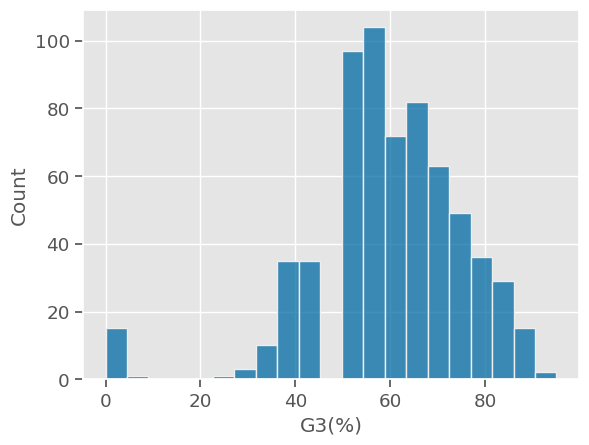

In [4]:
## visual distribution of % grades
ax = sns.histplot(data=df, x='G3(%)')

In [5]:
## defining bin edges
bins = [0,60,70,80,90,100]

grades = pd.cut(df['G3(%)'], bins=bins)
grades.value_counts().sort_index()

(0, 60]      358
(60, 70]     145
(70, 80]      85
(80, 90]      44
(90, 100]      2
Name: G3(%), dtype: int64

- Looking at the value counts above, we can see the name of the first group is: "(0,60]", the second is "(60,70]" and so on. 
    - When displaying intervals/bins, pandas uses square brackets to indicate when the number is INCLUDED in the bin or a round bracket if the number is not included in the bin. 
    
    
- So in the example above:
    - (0,60]: does include 0, but does include 60, we the logic it is capturing if  0<x<=60
        - But we want to include 0 in the bin and DON'T want to include 60. 
        
There are a couple of ways we can address this:

- We can change this by providing additional arguments to `pd.cut`:
    - right: "Indicates whether `bins` includes the rightmost edge or not." default is True.
    - If we say right=False, then the logic will change to match what we wanted, where scores up to 60 (but not 60) are defined as an F.


In [6]:

grades = pd.cut(df['G3(%)'], bins=bins,right=False)
grades.value_counts(dropna=False)

[0, 60)      301
[60, 70)     154
[70, 80)     112
[80, 90)      65
[90, 100)     17
Name: G3(%), dtype: int64

- The downside to this approach is that 100 will no longer be included in the last bin, so we would to increase the final bin edge to 101.
        

In [7]:
bins = [0,60,70,80,90,101]
grades = pd.cut(df['G3(%)'], bins=bins,right=False)
grades.value_counts()

[0, 60)      301
[60, 70)     154
[70, 80)     112
[80, 90)      65
[90, 101)     17
Name: G3(%), dtype: int64

### Adding Bin labels and saving as a column

In [8]:
## defining bins and their labels
bins = [0,60,70,80,90,101]
bin_labels = ['F','D','C','B','A']
grades = pd.cut(df['G3(%)'],bins, labels=bin_labels,include_lowest=True)
grades.value_counts()

F    373
D    145
C     85
B     44
A      2
Name: G3(%), dtype: int64

In [9]:
df['FinalGrade'] = pd.cut(df['G3(%)'],bins, labels=bin_labels,include_lowest=True)
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,G3(%),FinalGrade
0,GP,F,18.0,U,GT3,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,no,no,4.0,3.0,4.0,1.0,1.0,3.0,4.0,0.0,11.0,11.0,55.0,F
1,GP,F,17.0,U,GT3,T,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,1.0,1.0,3.0,2.0,9.0,11.0,11.0,55.0,F
2,GP,F,15.0,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,0.0,yes,no,no,no,yes,yes,yes,no,4.0,3.0,2.0,2.0,3.0,3.0,6.0,12.0,13.0,12.0,60.0,F
3,GP,F,15.0,U,GT3,T,4.0,2.0,health,services,home,mother,1.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,yes,3.0,2.0,2.0,1.0,1.0,5.0,0.0,14.0,14.0,14.0,70.0,D
4,GP,F,16.0,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,no,no,yes,yes,no,no,4.0,3.0,2.0,1.0,2.0,5.0,0.0,11.0,13.0,13.0,65.0,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19.0,R,GT3,T,2.0,3.0,services,other,course,mother,1.0,3.0,1.0,no,no,no,yes,no,yes,yes,no,5.0,4.0,2.0,1.0,2.0,5.0,4.0,10.0,11.0,10.0,50.0,F
645,MS,F,18.0,U,LE3,T,3.0,1.0,teacher,services,course,mother,1.0,2.0,0.0,no,yes,no,no,yes,yes,yes,no,4.0,3.0,4.0,1.0,1.0,1.0,4.0,15.0,15.0,16.0,80.0,C
646,MS,F,18.0,U,GT3,T,1.0,1.0,other,other,course,mother,2.0,2.0,0.0,no,no,no,yes,yes,yes,no,no,1.0,1.0,1.0,1.0,1.0,5.0,6.0,11.0,12.0,9.0,45.0,F
647,MS,M,17.0,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,yes,yes,no,2.0,4.0,5.0,3.0,4.0,2.0,6.0,10.0,10.0,10.0,50.0,F


### Making Our Final Target & X/y Data

In [10]:
## Define target as had a F or Above
df['target_F'] = df['FinalGrade'] == 'F'
df['target_F'].value_counts(normalize=True)

True     0.57473
False    0.42527
Name: target_F, dtype: float64

In [11]:
# ### Train Test Split
## Make x and y variables
drop_feats = ['G1','G2','G3','G3(%)','FinalGrade']
y = df['target_F'].copy()
X = df.drop(columns=['target_F',*drop_feats]).copy()


## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)


# ### Preprocessing + ColumnTransformer

## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')

## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))

num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)


## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)

feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)


X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
104,15.0,3.0,4.0,1.0,2.0,0.0,5.0,4.0,4.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
284,18.0,2.0,1.0,1.0,1.0,2.0,3.0,2.0,5.0,2.0,5.0,5.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
579,18.0,1.0,3.0,1.0,1.0,0.0,4.0,3.0,3.0,2.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


## RandomForestClassifier

### Function for Evaluating Classification Models

In [12]:
def evaluate_classification(model, X_train,y_train,X_test,y_test,
                            normalize='true',cmap='Blues', figsize=(10,5)):
    header="\tCLASSIFICATION REPORT"
    dashes='--'*40
    print(f"{dashes}\n{header}\n{dashes}")

    ## training data
    print(f"[i] Training Data:")
    y_pred_train = model.predict(X_train)
    report_train = metrics.classification_report(y_train, y_pred_train)
    print(report_train)

    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_train,y_train,
                                                  normalize=normalize, 
                                                  cmap=cmap,ax=ax[0])
    try:
        metrics.RocCurveDisplay.from_estimator(model,X_train,y_train,ax=ax[1])
        ax[1].plot([0,1],[0,1],ls=':')
        ax[1].grid()
    except:
        pass
    fig.tight_layout()
    
    plt.show()

    
    print(dashes)
    ## training data
    print(f"[i] Test Data:")
    y_pred_test = model.predict(X_test)
    report_test = metrics.classification_report(y_test, y_pred_test)
    print(report_test)

    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,
                                                  normalize=normalize, 
                                                  cmap=cmap, ax=ax[0])
    try:
        metrics.RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax[1])
        ax[1].plot([0,1],[0,1],ls=':')
        ax[1].grid()
    except:
        pass
    fig.tight_layout()
    plt.show()

--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       205
        True       1.00      1.00      1.00       281

    accuracy                           1.00       486
   macro avg       1.00      1.00      1.00       486
weighted avg       1.00      1.00      1.00       486



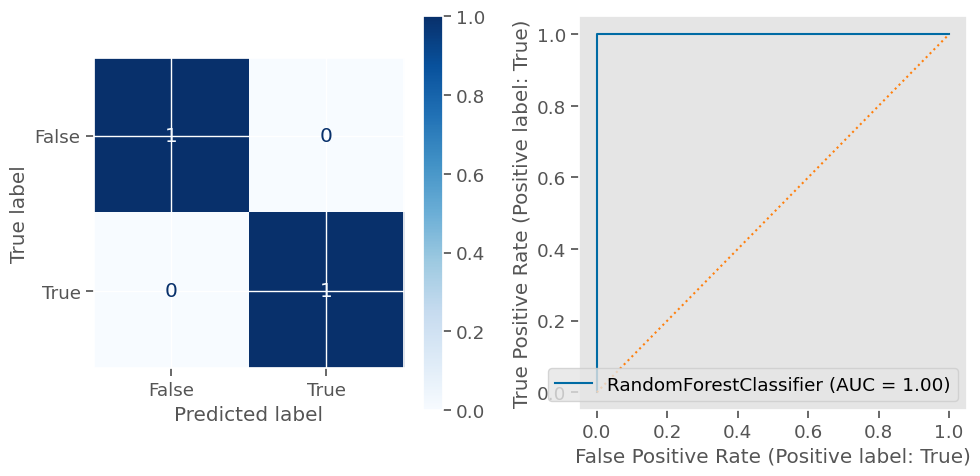

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.81      0.70      0.75        71
        True       0.79      0.87      0.83        92

    accuracy                           0.80       163
   macro avg       0.80      0.79      0.79       163
weighted avg       0.80      0.80      0.80       163



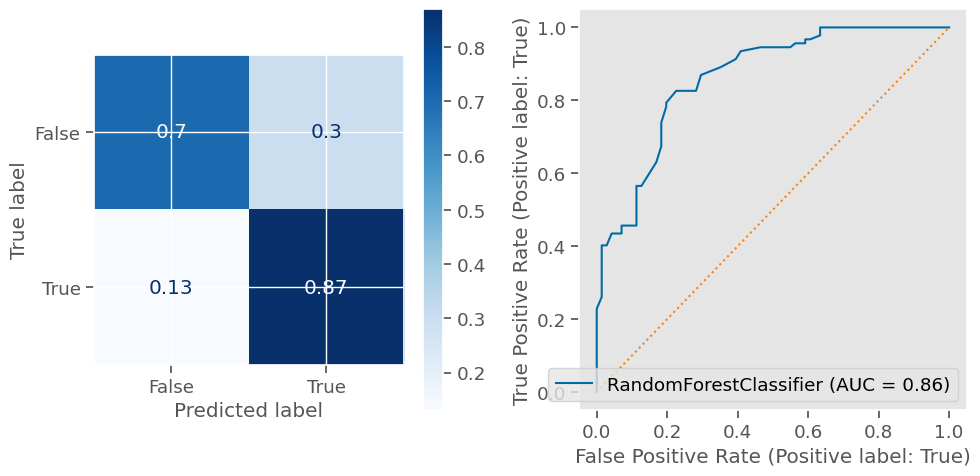

In [13]:
## fit random fores
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_df,y_train)
evaluate_classification(rf_clf,X_train_df,y_train, X_test_df,y_test)

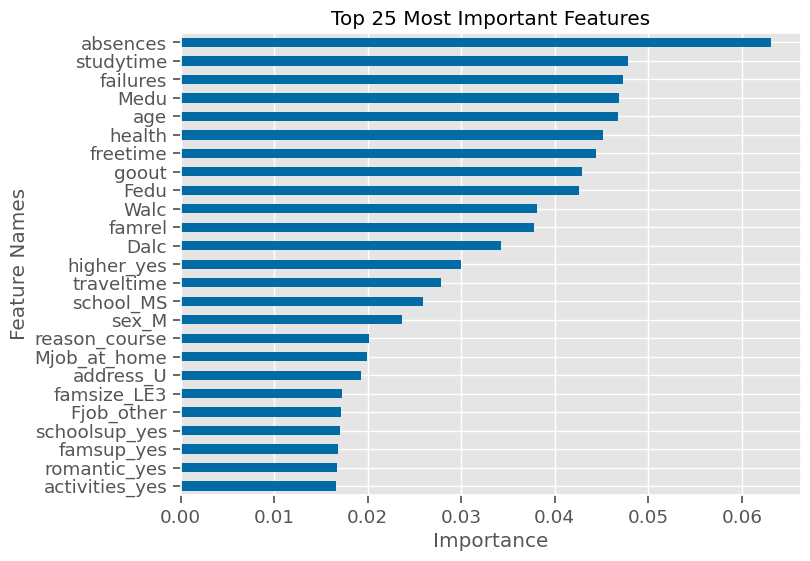

In [14]:
rf_importances = get_importances(rf_clf)
ax = plot_importance(rf_importances,top_n=25)

In [15]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rf_clf,X_train_df,y_train,n_jobs=-1,n_repeats=5)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [16]:
## getting the colors for the top 7 important rf features
colors_rf = get_color_dict(rf_importances,top_n=7)

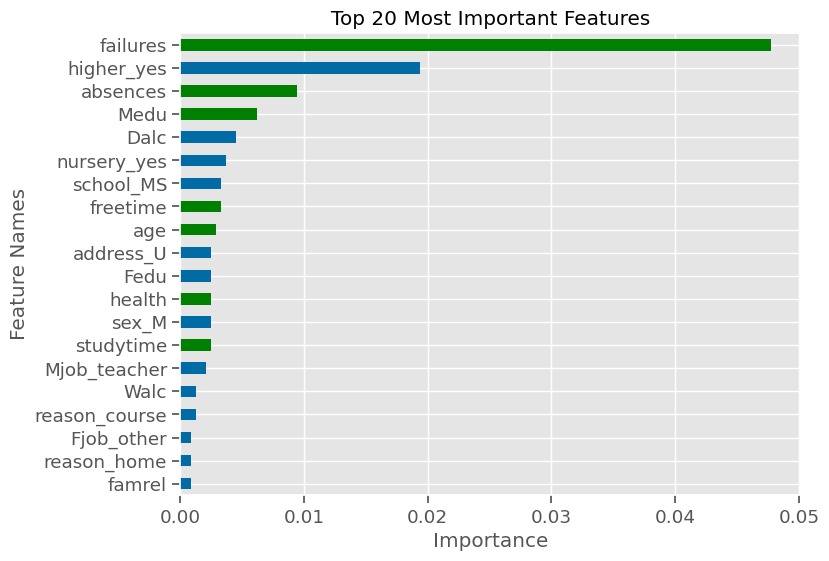

In [17]:
## can make the mean importances into a series
rf_perm_importances = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'permutation importance')
rf_perm_importances = rf_perm_importances.sort_values(ascending=False)
plot_importance_color(rf_perm_importances,color_dict=colors_rf,top_n=20);

# L05: Model Explainers - Global

## To Do:
- Update cropped summary plots
    - replace example higher_no summary plot with higher_yes


## Using SHAP for Model Interpretation

- SHAP (SHapley Additive exPlanations)) 
    - [Repository](https://github.com/slundberg/shap)
    - [Documentation](https://shap.readthedocs.io/en/latest/?badge=latest)
  

- SHAP is a package that leverages game theory and the idea of marginal contributions to determine how the features effect the model's preditons.

- The shap package will use your model to iteratively remove features from the data set and evaluate the change in the model's predictions.

- The result of this process is a set of Shapely values (or shap values). 
- The "marginal contribution" of the feature to the model's performance.

Shap will produce what is called a global explanation. In other words, it will explain how the model made its predictions for the entire dataset.
- In an upcoming lesson, we will explore local explanations, which are explanations about a single row/observation.

- For more details about the inner-workings of the shap package, see the white papers and articles linked below.

### Additional Resources

#### Technical Papers
- White Paper on Shapely Values: [Lundberg & Lee 2017](https://arxiv.org/abs/1705.07874)
- White Paper from Nature Machine Learning: [Lundberg et al 2020](https://rdcu.be/b0z70)

####  Book Excerpts, and  Blogs
- [Intepretable Machine Learning Book - Section on SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)
    
- Towards Data Science Blog Posts:
    - [Explain Your Model with SHAP Values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

    - [Explain Any Model with SHAP KernelExplaibner](https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a)

#### Videos/Talks:
- Explaining Machine Learning Models (in general).
    - ["Open the Black Box: an intro to Model Interpretability with LIME and SHAP](https://youtu.be/C80SQe16Rao)
- Understanding Shapely/SHAP Values:
    - [AI Simplified: SHAP Values in Machine Learning ](https://youtu.be/Tg8aPwPPJ9c)- (Intuitive Explanation)
    - [Explainable AI explained! | #4 SHAP  ](https://youtu.be/9haIOplEIGM)- (Math Calculation Explanation)

## Explaining Our Model

- We will be using our random forest model from the prior lesson. Let's remind ourselves of its performance and feature importances.

--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       205
        True       1.00      1.00      1.00       281

    accuracy                           1.00       486
   macro avg       1.00      1.00      1.00       486
weighted avg       1.00      1.00      1.00       486



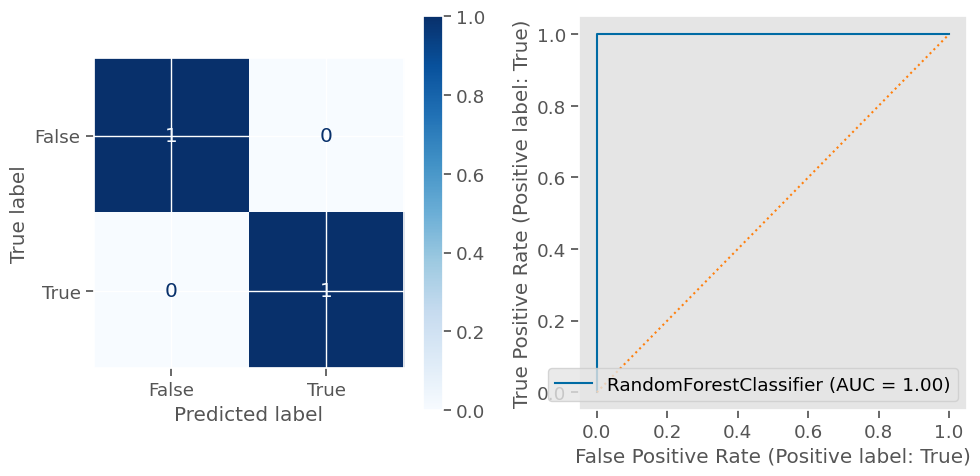

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.81      0.70      0.75        71
        True       0.79      0.87      0.83        92

    accuracy                           0.80       163
   macro avg       0.80      0.79      0.79       163
weighted avg       0.80      0.80      0.80       163



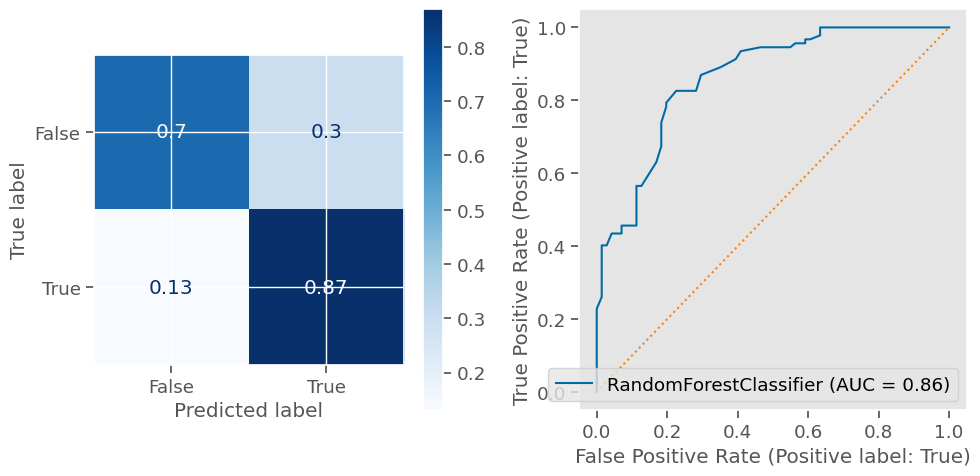

In [18]:
evaluate_classification(rf_clf,X_train_df,y_train, X_test_df,y_test)

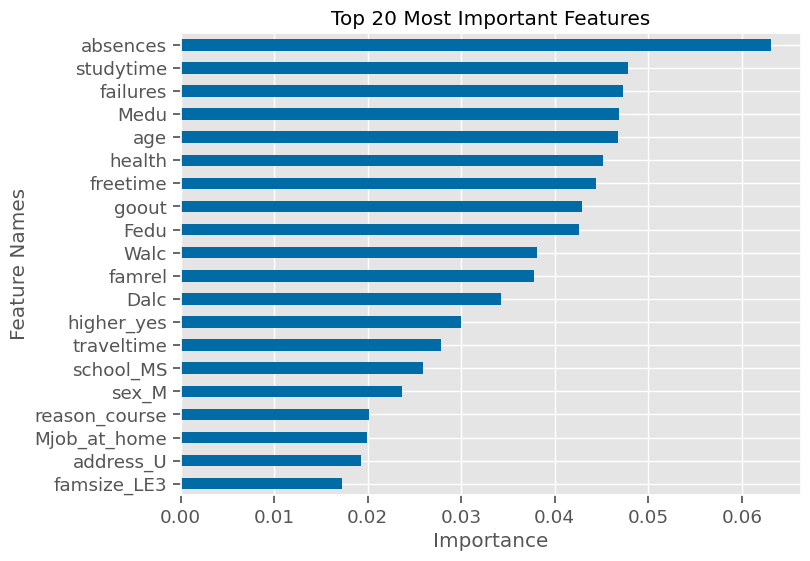

In [19]:
rf_importances = get_importances(rf_clf)
plot_importance(rf_importances,top_n=20);

### How To Use Shap

- There are several Shap plots that are interactive and require javascript to be loaded. We can do this via the initjs() function in shap.




In [20]:
# Import shap and initialize javascript:
import shap
shap.initjs()

### Shap Explainers

- In order to calculate our shap values for our model & features, we will need to create an instance of a Model Explainer. 

- Explainer objects will need the model and some X and y data.

### Preparing Data for Shap

- Shap's approach to explaining models can be very resource-intensive for complex models such as our RandomForest.
- To get around this issue, shap includes a convenient smapling function to save a small sample from one of our X variables.
- If we check the length of our X data, we can see how many rows we have.


In [21]:
len(X_train_df)

486

- 486 may be fine, or it could be a bit much for your local machine. 

- Whenever the dataset is too large for your machine to process in a timely manner, we can use shap's utility for sampling a subset of our data (shap.sample).

- Let's take just 200 observations from our x_data and save it as X_shap.

In [22]:
X_train_df.shape, X_test_df.shape

((486, 43), (163, 43))

In [23]:
X_shap = shap.sample(X_train_df,nsamples=400,random_state=321)
X_shap

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
473,16.0,2.0,1.0,2.0,1.0,0.0,2.0,4.0,3.0,2.0,3.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
340,17.0,3.0,3.0,1.0,1.0,0.0,4.0,4.0,3.0,1.0,3.0,5.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
452,16.0,2.0,2.0,3.0,2.0,0.0,4.0,4.0,5.0,1.0,1.0,4.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
555,16.0,1.0,2.0,1.0,3.0,0.0,4.0,3.0,4.0,1.0,1.0,3.0,5.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
70,16.0,3.0,1.0,2.0,4.0,0.0,4.0,3.0,2.0,1.0,1.0,5.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,17.0,2.0,2.0,2.0,2.0,0.0,4.0,3.0,5.0,1.0,2.0,4.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
329,17.0,2.0,2.0,1.0,2.0,0.0,5.0,4.0,5.0,1.0,2.0,5.0,12.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
251,16.0,2.0,1.0,1.0,1.0,0.0,4.0,5.0,2.0,1.0,1.0,5.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
434,16.0,2.0,2.0,2.0,4.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


- Since we re-made our X_train_df using the index from the original X, we can use the index of X_shap to slice out the y-data that corresponds to our samples.

In [24]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap 

473     True
340    False
452     True
555    False
70      True
       ...  
485     True
329    False
251     True
434     True
568     True
Name: target_F, Length: 400, dtype: bool

### Explaining Our RandomForest

- shap has several types of model explainers that are optimized for different types of models. 


#### Explainers and their use cases:


| Explainer                         | Description                                                                                    |
|:----------------------------------|:-----------------------------------------------------------------------------------------------|
| **shap.Explainer**                    | Uses Shapley values to explain any machine learning model or python function.  ***Automatically selects one of the following explainers for the type of model you are using***                |
| shap.explainers.Tree              | Uses Tree SHAP algorithms to explain the output of ensemble tree models.                       |
| shap.explainers.Linear            | Computes SHAP values for a linear model, optionally accounting for inter-feature correlations. |
| shap.explainers.Permutation       | This method approximates the Shapley values by iterating through permutations of the inputs.   |
| shap.explainers.Sampling          | This is an extension of the Shapley sampling values explanation method (aka.                   |
| shap.explainers.Additive          | Computes SHAP values for generalized additive models.                                          |
| shap.explainers.other.Coefficent  | Simply returns the model coefficents as the feature attributions.                              |
| shap.explainers.other.Random      | Simply returns random (normally distributed) feature attributions.                             |


<!-- | shap.explainers.other.LimeTabular | Simply wrap of lime.lime_tabular.LimeTabularExplainer into the common shap interface.          |
| shap.explainers.other.Maple       | Simply wraps MAPLE into the common SHAP interface.                                             |
| shap.explainers.other.TreeMaple   | Simply tree MAPLE into the common SHAP interface.                                              |
| shap.explainers.other.TreeGain    | Simply returns the global gain/gini feature importances for tree models.                       |
 -->
        

### Explainers and their use cases: V2 09/21/22


| Explainer                         | Description                                                                                    |
|:----------------------------------|:-----------------------------------------------------------------------------------------------|
| **shap.Explainer**                    | Uses Shapley values to explain any machine learning model or python function.<br>***Automatically selects one of the following explainers for the type of model you are using***                |
| shap.explainers.Tree              | Uses Tree SHAP algorithms to explain the output of ensemble tree models.                       |
| shap.explainers.Linear            | Computes SHAP values for a linear model, optionally accounting for inter-feature correlations. |
| shap.explainers.Permutation       | This method approximates the Shapley values by iterating through permutations of the inputs.   |



1. Create a shap explainer using your fit model.

```python
explainer = shap.Explainer(rf_reg)
```

2. Get shapely values from explainer for your training data

```python
shap_values = explainer(X_shap,y_shap)
```            

3. Select which type of the available plots you'd like to visualize

    
- **Types of Plots:**
    - `summary_plot()`
    - `dependence_plot()`
    - `force_plot()` for a given observation
    - `force_plot()` for all data
    
  

In [25]:
explainer = shap.Explainer(rf_clf)
explainer

- As we can see above, shap.Explainer recognized that we are using a tree based model and it create a TreeExplainer. 
- Now that we have the explainer, we need to provide then X and y data.
- The explainer will use a copy of our model to iterate through all of the features to calculate the marginal contribution of each feature to the model's predictions.
- These contributions will be represented as shap values, which we will interpret to explain our model.

#### Import Note about Shap Changes
- Recently, shap updated its functions to return a special class for shap values called Explanations.

- Many of the examples in articles and tutorials on the internet are examples of the old way to using shap.
    - These approaches will still work, but they return simple numpy matrices instead of the special shap value class. 
    - See the Examples in the Appendix for examples of the older approach.

In [26]:
## Getting the shap values
shap_values = explainer(X_shap,y_shap)
type(shap_values)

shap._explanation.Explanation

In [27]:
X_shap.shape

(400, 43)

In [28]:
shap_values.shape

(400, 43, 2)

- We can see that shap calculated values for all 200 rows and 56 columns in our X_shap variable.
- Notice that the 3rd dimension is 2. 
    - This is because our classification task has 2 classes. If we had more classes, we would have the same number as we have classes.
    

#### Exploring Shap Explanation Values

- What does the first row's shap values look like?

In [29]:
shap_values[0]

.values =
array([[-1.15165368e-02,  1.15165368e-02],
       [-2.00970183e-02,  2.00970183e-02],
       [-3.73278511e-02,  3.73278511e-02],
       [-1.30577180e-02,  1.30577180e-02],
       [-6.02032650e-02,  6.02032650e-02],
       [ 1.82659012e-02, -1.82659012e-02],
       [-2.60672307e-02,  2.60672307e-02],
       [-5.23592261e-03,  5.23592261e-03],
       [-1.03872516e-02,  1.03872516e-02],
       [-2.83196172e-02,  2.83196172e-02],
       [-2.07484363e-02,  2.07484363e-02],
       [-5.73616057e-03,  5.73616057e-03],
       [-1.13086674e-02,  1.13086674e-02],
       [-4.39675434e-02,  4.39675434e-02],
       [-3.55386270e-02,  3.55386270e-02],
       [ 1.27171520e-03, -1.27171520e-03],
       [-5.32930678e-03,  5.32930678e-03],
       [-2.30715695e-03,  2.30715695e-03],
       [-4.69512766e-02,  4.69512766e-02],
       [-1.45327285e-03,  1.45327285e-03],
       [-5.67660591e-03,  5.67660591e-03],
       [-3.72593331e-04,  3.72593331e-04],
       [-2.87157566e-03,  2.87157566e-03],
 

In [30]:
type(shap_values[0])

shap._explanation.Explanation

In [31]:
## saving the first explanation to explore
explanation_0 = shap_values[0]
explanation_0

.values =
array([[-1.15165368e-02,  1.15165368e-02],
       [-2.00970183e-02,  2.00970183e-02],
       [-3.73278511e-02,  3.73278511e-02],
       [-1.30577180e-02,  1.30577180e-02],
       [-6.02032650e-02,  6.02032650e-02],
       [ 1.82659012e-02, -1.82659012e-02],
       [-2.60672307e-02,  2.60672307e-02],
       [-5.23592261e-03,  5.23592261e-03],
       [-1.03872516e-02,  1.03872516e-02],
       [-2.83196172e-02,  2.83196172e-02],
       [-2.07484363e-02,  2.07484363e-02],
       [-5.73616057e-03,  5.73616057e-03],
       [-1.13086674e-02,  1.13086674e-02],
       [-4.39675434e-02,  4.39675434e-02],
       [-3.55386270e-02,  3.55386270e-02],
       [ 1.27171520e-03, -1.27171520e-03],
       [-5.32930678e-03,  5.32930678e-03],
       [-2.30715695e-03,  2.30715695e-03],
       [-4.69512766e-02,  4.69512766e-02],
       [-1.45327285e-03,  1.45327285e-03],
       [-5.67660591e-03,  5.67660591e-03],
       [-3.72593331e-04,  3.72593331e-04],
       [-2.87157566e-03,  2.87157566e-03],
 

- Each entry in the shap_values array is new type of object called an Explanation.
    - Each Explanation has:
        - values:
            - the shap values calculated for this observation/row. 
            - For classification models, there is a column with values for each target.
        - base_values: 
            - the final shap output value
        - data:
            - the original input feature

In [32]:
## Showing .data is the same as the raw X_shap
explanation_0.data

array([16.,  2.,  1.,  2.,  1.,  0.,  2.,  4.,  3.,  2.,  3.,  4.,  4.,
        1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,
        1.,  1.,  1.,  0.])

In [33]:
X_shap.iloc[0].values

array([16.,  2.,  1.,  2.,  1.,  0.,  2.,  4.,  3.,  2.,  3.,  4.,  4.,
        1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,
        1.,  1.,  1.,  0.])

In [34]:
## showing the .values
pd.DataFrame(explanation_0.values,index=X_shap.columns)

,0,1
age,-0.011517,0.011517
Medu,-0.020097,0.020097
Fedu,-0.037328,0.037328
traveltime,-0.013058,0.013058
studytime,-0.060203,0.060203
failures,0.018266,-0.018266
famrel,-0.026067,0.026067
freetime,-0.005236,0.005236
goout,-0.010387,0.010387
Dalc,-0.028320,0.028320


- Now that we have our shap values, we are ready to start exploring Shap visualizations!

# Shap Global Explanations for Classification

> `NOTE TO BRENDA: should we deviate from naming conventions and name the shap_values above something else like explanations and then save just the 1 class we care about as shap values?`

- The first type of plot we will explore is the summary plot.
- In order to visualize the effect of the features on a specific class, we need to select the dimension that corresponds to our target of interest. 

- Since we want to explain which students will Fail - which is our 1 class, we will want to use the second dimension (the first is our 0 class).

- Since the 3rd dimension of our shap explanations was the # of classes, we will want to slice out all rows, all columns, and index=1 for the final dimension.
    - `shap_values[:,:,1]`
- We will be focusing on explaining just this class, so we can save that class's data as a new variable.

In [35]:
## Brenda: which name to use?
# shap_vals_fail = shap_values[:,:,1]
shap_vals_1 = shap_values[:,:,1]
shap_vals_1.shape

(400, 43)

- As we can see above, we now only have 2 dimensions, rows and columns.

## Summary Plot

- `NOTE to Brenda/James: change the first variable in examples to match final naming convention`

```python
## For normal bar graph of importance:
shap.summary_plot(shap_values[:,:,1],features=X_shap, plot_type='bar')

## For detail Shapely value visuals:
shap.summary_plot(shap_values[:,:,1], features=X_shap)
```
  

**`shap.summary_plot`**
> - Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.


>- **IMPORTANT NOTE:** You may need to slice out the correct shap_values for the target class. (by default explainer.shap_values seems to return a list for a binary classification, one set of shap values for each class).
    - This will cause issues like the summary plot having a bar with an equal amount of blue and red for each class. 
    - To fix, slice out the correct matrix from shap_values [0,1]


### Summary Plot - Bar 

- First, let's examine a simple version of our shap values. 
    - By using the plot_type="bar" version of the summary plot, we get something that looks very similar to the feature importances we discussed previously. 
    

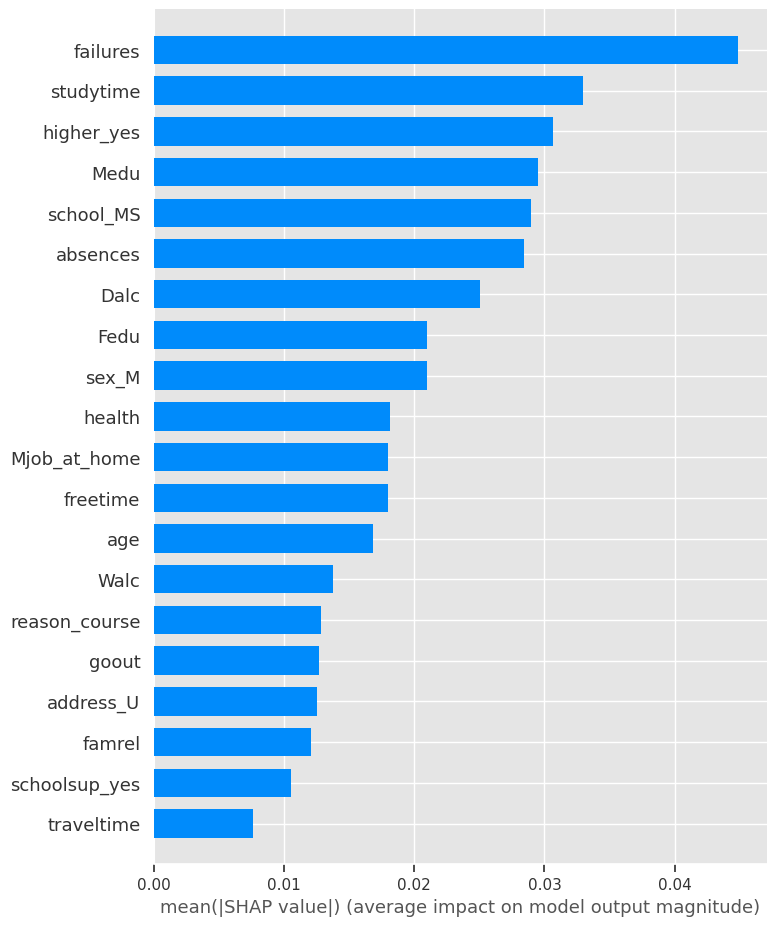

In [36]:
shap.summary_plot(shap_vals_1,features= X_shap, plot_type='bar')

- In this case, it is using the magnitude of the average shap values to to show which features had the biggest impact on the model's predictions.
- Let's remind ourselves what our random forest calculated as the feature importances

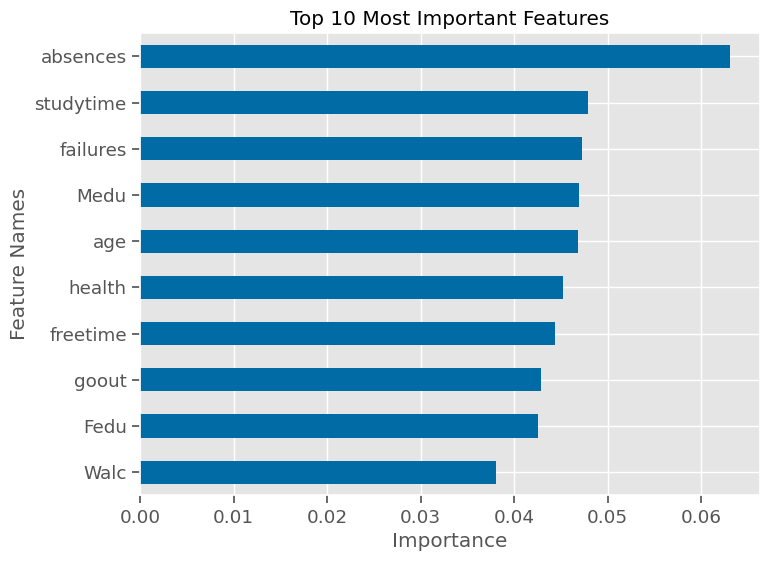

In [37]:
plot_importance(rf_importances,top_n=10);

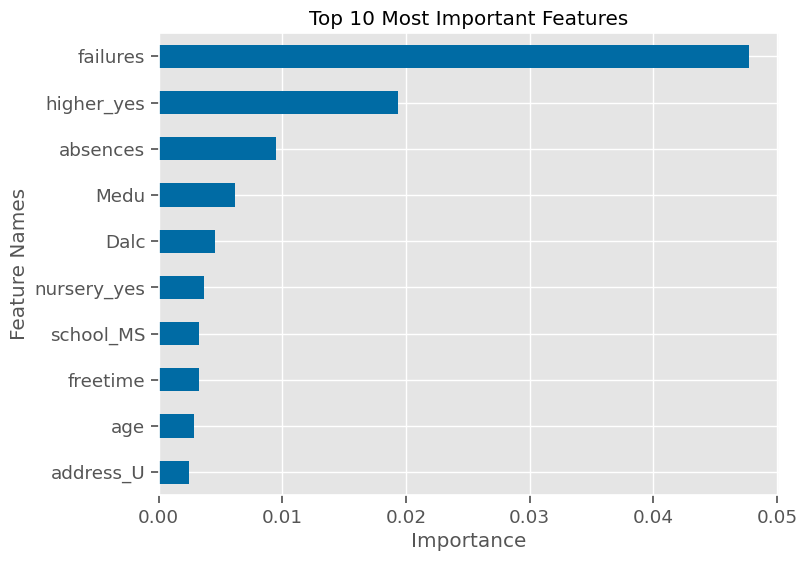

In [38]:
plot_importance(rf_perm_importances,top_n=10);

- As we can see above, shap's importances are different from the built-in random forest importances. 
- It is also different from the permutation importances. However, the permutation importances and shap importances featured similar important features that were undervalued by the random forest (e.g. higher_no)

- Like feature importance and permutation importance, this visualization is not indicating which **direction** the features push the predict.
- Let's remove the plot_type='bar' argument and examine the default plot type that will provide this information.
    

### Summary Plot - dot (default)

- Now, let's examine the "dot" version of the summary plot. 
- By removing the plot_type argument, we are using the default, which is "dot". 
    - We could explicitly specify plot_type="dot".
        - There are also additional plot types that we will not be discussing in this lesson (e.g. "violin","compact_dot")

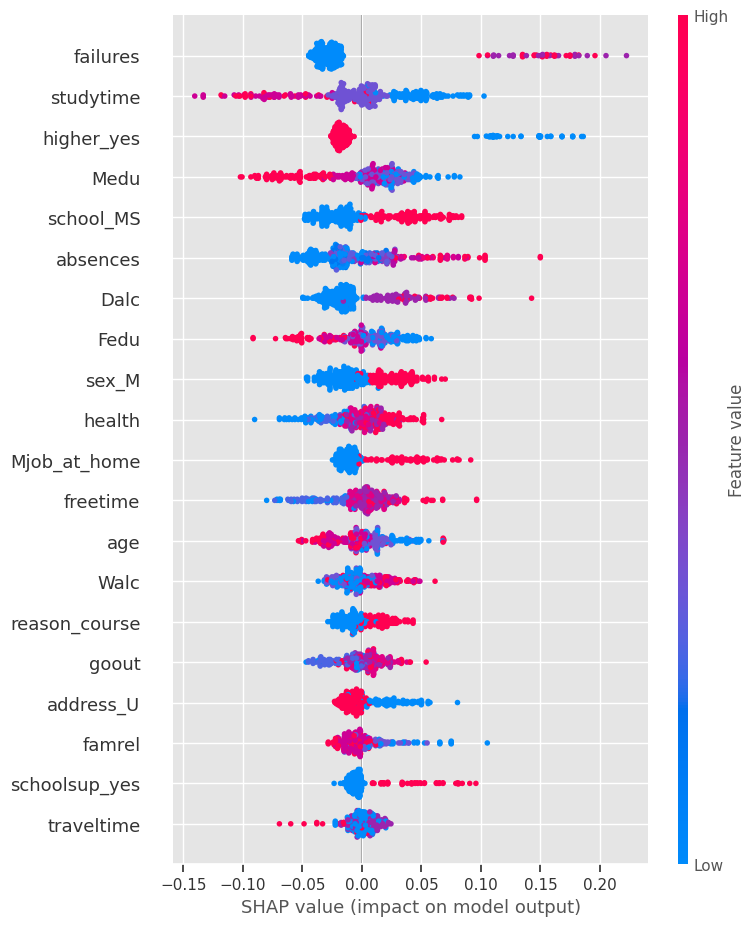

In [39]:
shap.summary_plot(shap_vals_1,X_shap)

Now THAT is a lot more nuanced of a visualization!
Let's break down how to interpret the visual above.

### Reading Shap Summary Plots

- In the summary plot above:
    - Each dot represents an observation/row (in this case, a student).
    - The **features are plotting on the y-axis**, and are sorted from the most
impactful features to the least (from top to bottom).
    - The **calculated Shapely values for each observation** are plotted on the x-axis. The most positive the value the more the feature pushed the model's prediction towards predicting the current class.
    - For each feature, the original values of that feature are represented with color. 
        - Using the default colormap, blue represents the lowest value in the column and red represents the highest. 
            - For one hot encoded categories, blue=0, red = 1.
            - For numeric features: the shade of the color indicates where it falls in the feature's distribution.


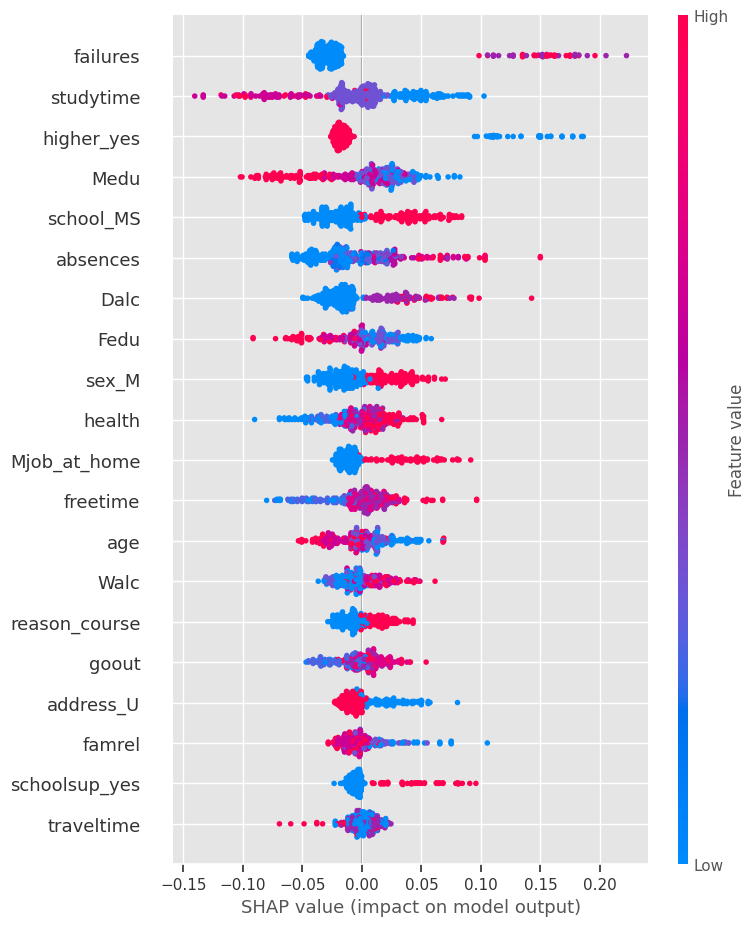

In [40]:
shap.summary_plot(shap_vals_1,X_shap)

### Interpreting the shap values for our model:

##### failures

<img src="images/Shap Summary Plot_failures.png" width=400px>
- We can see that the greater the # of failures a student had the more likely the model would predict the student will Fail.

- We can see that having a high number of failures pushed the model's prediction heavily towards being a failure (as judged by how far to the right of the yaxis/0-line the red samples are located).
    - Notice that the blue dots (fewer failures) are only slightly to the left of the 0-line, indicating the the model is only slightly less likely to predict a failure, compared to the big impact of having a large number of failures.

##### studytime


<img src="images/Shap Summary Plot_studytime.png" width=400px>

- Study time had the largest effect on the model's predictions (since it was the first bar at the top of the graph). 
- We can see that the lower the study time (the blue dots) the more likely the model will predict the student will fail (blue dots are on the right of the vertical 0 line).

- We can see that students with the highest studytime (red dots), are predicted to be much less likely to fail.
    - `BRENDA: revisit phrasing of interpretation`
    

##### higher_no [NEEDS REPLACEMENT]


<img src="images/Shap Summary Plot_higher_no.png" width=400px>

- higher_no is our first One-Hot-Encoded to interpret with shap. Since it is OHE, the values in this feature are either 0 or 1, which translates to blue=0 and red=1.
    - Therefore, we can see that if higher_no==1 (meaning the student does NOT intend to pursue higher education - the red dots) then the model is much more likely to predict the student will fail. 
    - If higher_no==0 (the blue dots), the model is less likely to predict the student will fail.

#### Important Note

- Remember, our shap explanations and visualizations are explaining how our **model** was using the features and how they influenced the model's prediction.
- It is not explaining the real-world situation. So always keep that in mind when interpreting shap visualizations.

### Saving Summary Plots

- Exporting images of our figures can be tricky with shap. It does not return an axis or a figure, so there is no variable we can use to represent the figure.

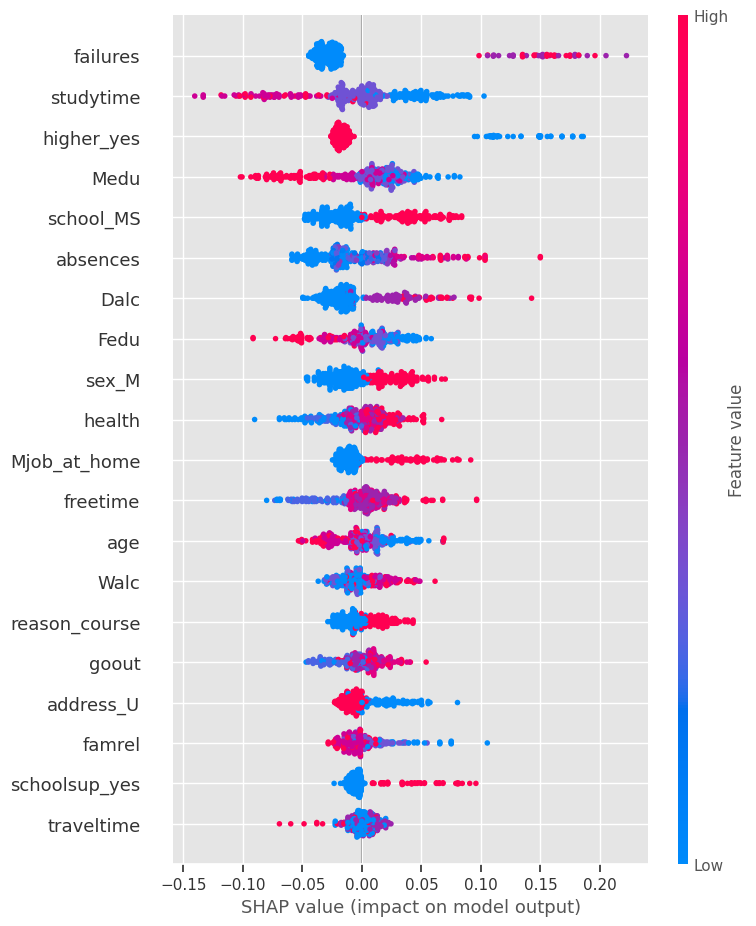

In [41]:
fig = shap.summary_plot(shap_vals_1,X_shap,)

In [42]:
print(type(fig))
fig

<class 'NoneType'>


- The solution is to create a figure immediately before using the summary plot function (in the same cell)
- We can use `fig=plt.figure()`, `fig, ax = plt.subplots()`, `fig = plt.gcf()`
    - We will use the plt.subplots approach in this lesson, since it will create both the fig and axis.
    
- Note: if we do not add `show=False` to the summary_plot function, then the figure we will see will not represent the final up-to-date figure. 
    - notice what happens if we try to set the title below:

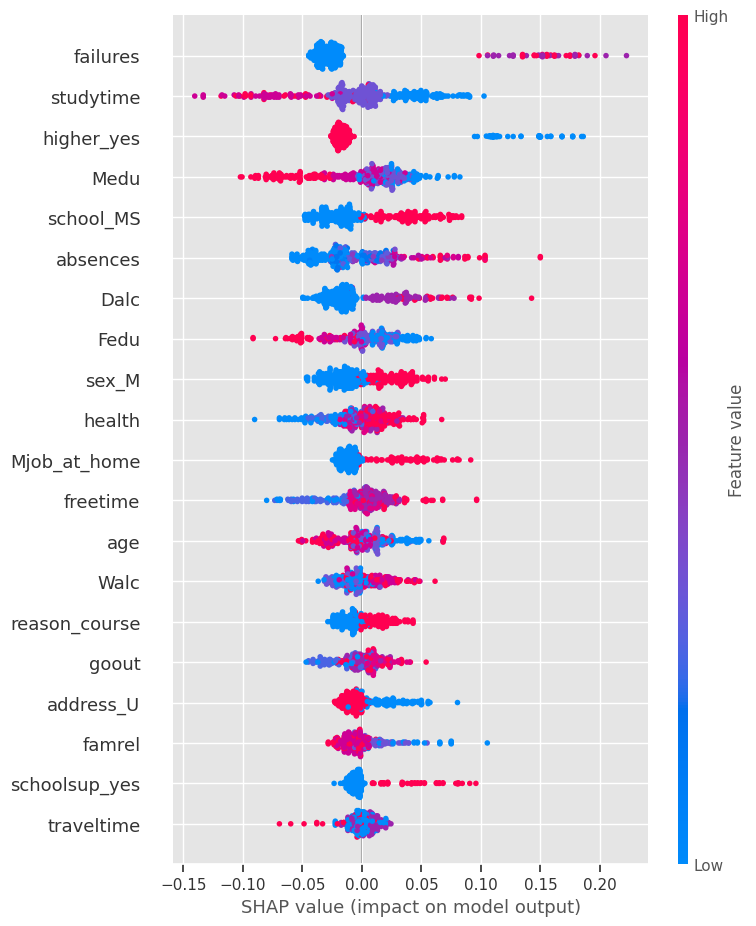

In [43]:
fig, ax = plt.subplots()
shap.summary_plot(shap_vals_1,X_shap)
ax.set_title('Summary Plot - Class=Fail');

- If we display the fig again, we will see the current final version (notice out title now appears)

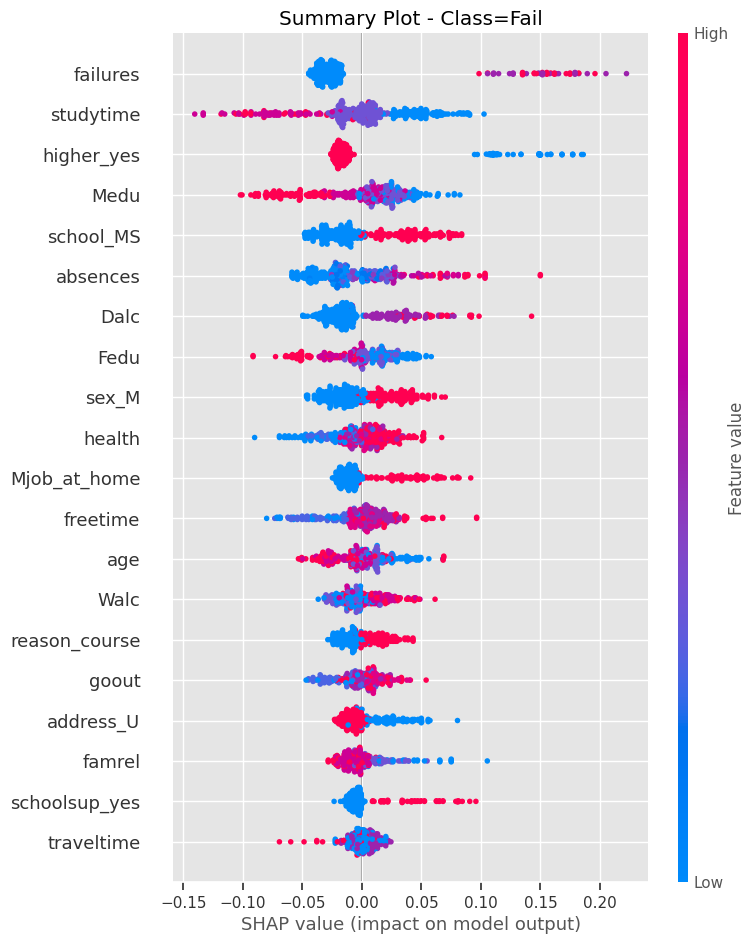

In [44]:
fig

#### Using fig.savefig

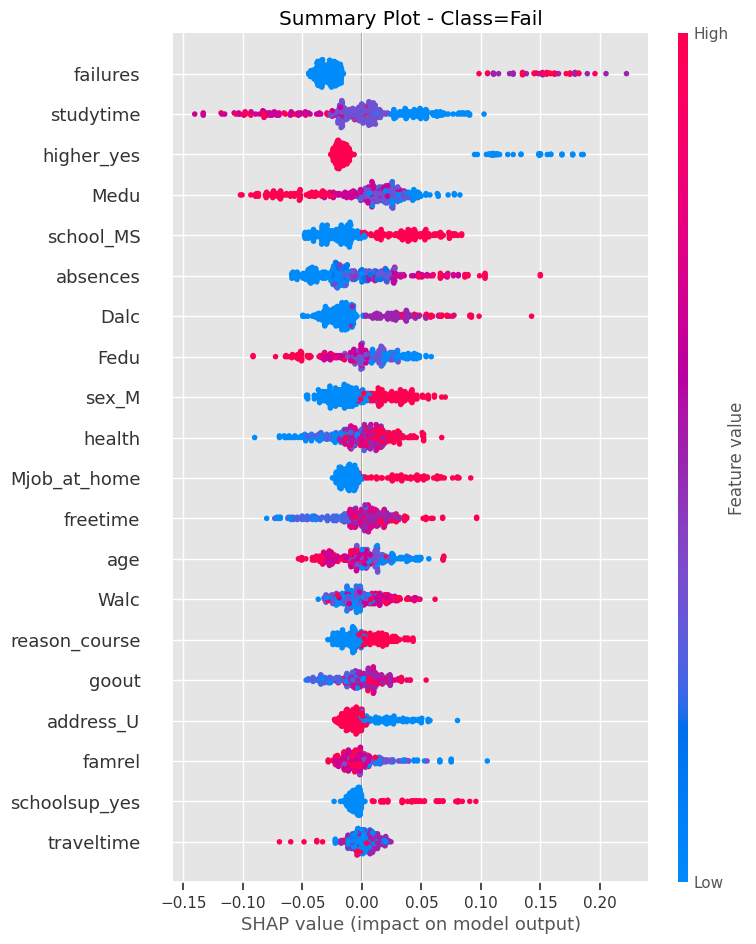

In [45]:
fig, ax = plt.subplots()
shap.summary_plot(shap_vals_1, X_shap, show=False)
ax.set_title('Summary Plot - Class=Fail');
fig.savefig('images/summary_plot_1.png')

- Now, let's insert this image into a markdown cell.
    - The most flexible way to insert an image is to use an html  `img` tag.
    - Image tags need the filepath as the "src" argument. 
    - We can also add additional style arguments to do things like resize our figure with the width argument. Below we are resizing to 60% of its original size. 
    
`<img src="images/summary_plot_1.png" width=60%>`    

- We could also use exact pixel values. We would use the letters "px" to indicate the units. 

`<img src="images/summary_plot_1.png" width=400px>`

  
- We can also control the plot alignment. We are centering the visualization below:    


<img src="images/summary_plot_1.png" width=60% align='center'>

### Recap - Shap Summary Plots


- As you can see, shap's explanations provide a much more detailed and nuanced perspective on how our model is making its predictions.
- While the summary plots can be a little tricky to read at first, with just a little practice you should find it much easier!

- Remember:
    - The values inside the feature are color coded.
    - The more negative the shap value, the less likely the model will predict the current class.
    - The more positive the shap value, the more likely the moedl will predict the current class.

## Force Plots

- Now that you've had some practice interpreting the meaning of shap values, let's explore shap's force_plot, which is an interactive function that will provide a global summary. 

### Intro to Force Plots - Single Observation

- Before we dive into the global version of shap's force plot, we will explore a simpler version first. We will plot the force plot for a single observations to acclimate to this new visualization before we move on to the global versions.
- Let's select a row to use for our force_plot.
    - In an upcoming lesson, we will discuss tactical selection of examples for stakeholders. 
    - For now, we are selecting an arbitrary row.

In [46]:
# arbitrarily choosing a row to use
i = 100
single_row_X = X_shap.iloc[i]
single_row_y = y_shap.iloc[i]
single_shap_vals = shap_vals_1[i]
single_row_X.head(10)

age           17.0
Medu           4.0
Fedu           3.0
traveltime     2.0
studytime      2.0
failures       0.0
famrel         4.0
freetime       4.0
goout          4.0
Dalc           4.0
Name: 189, dtype: float64

In [47]:
## true class of selected row
single_row_y

True

>- Note: Because force_plot is interactive, it requires javascript  (shap.initjs()) and that you ust Trust your jupyter notebook in order to display it.
    - In the top right corner of jupyter notebook, next the kernel name (Python (dojo-env)), click the `Not Trusted` button to trust the notebook.

- To create a force plot, the function requires:
    - the expected_value for the class of interest - which we can find in our explainer. 
    - The shap values for just that row and the features for just that row.
    - The features (X data) for just the 1 row.

In [48]:
## Individual forceplot (with the complex shap vals)
shap.force_plot(explainer.expected_value[1],shap_values=single_shap_vals.values,
               features=single_row_X)

![](Images/shap_force_plot_1.png)

### Reading an Individual Force Plot

- In the visual above, we can see:
    - a number line at the top of the visual (the base value).
        - `REVISIT PHRASING:` This is the same as the X-axis of the summary plot, where a value >0 represents a greater probability of predicting the 1 class and a value less than 0 indicates less likely of predicting the 1 class. 
    - Blue and red segments representing if the effect of a feature pushed the prediction more positive( red) or less positive (blue).
        - The observation's values are listed next to the name of the feature (e.g. Dalc=2.797)
        - The larger the segment for a feature is, the larger that features effect on the model's prediction.
    - The final output shap value is displayed in bold on the number line (where the blue and red features meet). 
        - In this example, our final shap value was 0.91, which is a positive number and reflects a prediction of 1 for the target.

        
Many of the feature names are displayed, but the features that had smaller contributions do not display their name by default. If you hover your mouse over the features, you can see their names.
    
    



#### Interpreting Our Example

In [49]:
## Individual forceplot (with the complex shap vals)
shap.force_plot(explainer.expected_value[1],shap_values=single_shap_vals.values,
               features=single_row_X)

![](Images/shap_force_plot_1.png)

- Looking at our force plot above, we can see that:
    - The prediction for this observation was positive (meaning Fail==True).
    - The feature with the largest effects (the largest segments) were Dalc and Walc.
    - These are both red, indicating they pushed the model's prediction higher.
    
- If we revisit the data dictionary, we can see that:
    - Dalc is "workday alcohol consumption (numeric: from 1 - very low to 5 - very high)"
    - Walc is "weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)"
- Therefore, our force plot is indicating the amount of alcohol consumed by this student were the most important features in determining the model's output.



### Global `shap.force_plot`

To show a global force plot, we will use the entire set of shap values and our X_shap variable, instead of our single example.


In [50]:
## Global Forceplot
shap.force_plot(explainer.expected_value[1],shap_vals_1.values,features=X_shap)

- Now, the above visualization may look a little overwhelming at first, but it isn't as bad as it seems if we remember how to read our individual force plot.
- In the individual example, we had the effect of the features on 1 row's prediction displayed horizontally, with the features color-coded based on their influence on the final prediction.

- The **global** force plot is essentially individual force plots (but for each row) rotated 90 degrees. 
    - Additionally, the force plot rearranged the rows in the data to sort them by similar values. 
    - This is why we see such a strong pattern in the example above.
    
    

### Using the Interactive Features of the Force Plot 

- Hovering over the figure will display the feature names and values.
- There are 2 drop down boxes (one on each axis) that control the values being displayed.
<img src="images/shap_force_plot_global-annotated.png">


#### Top Drop-down Menu

- The top drop-down menu along the x-axis controls the sorting of the rows. <br><img src="images/shap_force_plot_dropdown_2.png" width=200px>
    
- The default sorting based on similarity is generally going to be the cleanest sorting to interpret.

    - As we can see below, sorting by the original order makes it very difficult to read the visual.
<img src="images/shap_force_plot_order_original.png" width=600px>
     
     

     

#### Left Drop-down Menu

- The left dropdown menu along the y-axis controls what values are being plotted. <br><img src="images/shap_force_plot_dropdown_1.png" width=200px>


- By default, its plotting the overall output shap values, like in our individual force plot.
    - We can select an individual feature from this drop down to visualize only the effects of the one feature.
<img src="images/shap_force_plot_studytime.png" width=600px>

## Recap - Shap Global Explanations

- In this lesson, we learned how to implement the shap package and how to produce several key visualizations that provide additional insights and explanations for how our model determines its predictions.

- While there are even more visualizations you can explore, these are the most important for deriving global explanations.

- In the next lesson, we will discuss Local Explanations and introduce an additional explanation package - LIME.

In [51]:
raise Exception("end of lesson content!")

Exception: end of lesson content!

# APPENDIX:

### Saving Force Plots

> Note: could move to lesson 05

- If we want to export our force_plot, we will have to change our approach.
- If we save the output of shap.force_plot and check its type, we can see that we do not have a figure or an axis, we have a shap visualizer.

In [ ]:
## Individual forceplot (with the complex shap vals)
fig = shap.force_plot(explainer.expected_value[1],shap_values=single_shap_vals.values,
                features=single_row_X)

type(fig)

- In order to export this figure, we need to add `matplotlib=True`. However, using matplotlib will have an unintended consequence: it will use the matplotlib that we have been using.


In [ ]:
## Individual forceplot (with the complex shap vals)
fig = shap.force_plot(explainer.expected_value[1],shap_values=single_shap_vals.values,
                features=single_row_X, matplotlib=True)

type(fig)

- Notice that not only has our background changed, but the fig variable is empty. It did not save the fig.
- Using `fig=plt.gcf()` *after we make the force plot*  will allow us to save the figure, but we will still have the altered style

In [ ]:
## Individual forceplot (with the complex shap vals)

fig = shap.force_plot(explainer.expected_value[1],shap_values=single_shap_vals.values,
                features=single_row_X, matplotlib=True)

type(fig)

- To get around this, we can use matplotlib's function for temporarily setting the style back to the "default". But we want it to first reset ALL of the settings, so we will add `after_reset=True`

In [ ]:
## Individual forceplot (with the complex shap vals)
fig = shap.force_plot(explainer.expected_value[1],shap_values=single_shap_vals.values,
                features=single_row_X,show=False, matplotlib=True)



In [ ]:
with plt.style.context('default',after_reset=True):

    fig, ax = plt.subplots()
    ## Individual forceplot (with the complex shap vals)
    shap.force_plot(explainer.expected_value[1],shap_values=single_shap_vals.values,
                   features=single_row_X, matplotlib=True, 
                    show=True)
#     fig.savefig()
    fig = plt.gcf()
#     display(fig)
fig

## Exploring Individual Features with Shap

- Beyond an overall model summary, shap will also allow us to explore specific features and specific observations (rows) in-depth.


## Dependence Plots


- Shap includes a `shap.dependence_plot`, 
which shows how the model's output varies by a specific feature. 
- By passing the function 1 feature name, shap will automatically determine what features may driving the interactions with the selected feature. 
- It will encode the interaction feature as color.

- In order to run the dependence plot, we will need to provide the name of the feature to visualize, and the shap_vals_1. Specifically, JUST the shap_vals_1.values. If you try to provide the entire shap_vals_1 variable, you will receive an error.
```python
## To Auto-Select Feature Most correlated with a specific feature
shap.dependence_plot('Age', shap_values[:,:,1].values, X_shap)
```



### Exploring the Most Important Features

- Let's create dependence plots for each of the features we explored above.



In [ ]:
### ADMIN: TEST LOOP LOOKING FOR INTERESTING DEPENDENCE PLOTS
for col in X_shap.columns:
    shap.dependence_plot(col,shap_vals_1.values,features=X_shap)
    

In [ ]:
shap.dependence_plot("failures",shap_vals_1.values,features=X_shap)

In [ ]:
shap.dependence_plot("higher_yes",shap_vals_1.values,features=X_shap)

- ?Men are more likely to have failures?

In [ ]:
## Using shap_values made from shap_values = explainer(X_shap)
shap.dependence_plot("sex_M", shap_values[:,:,1].values,X_shap)

In [ ]:
## Using shap_values made from shap_values = explainer(X_shap)
shap.dependence_plot("studytime",shap_vals_1.values,features=X_shap)

### Comparing to XGBoost RandomForest

In [ ]:
import xgboost as xgb 
xgb_clf= xgb.XGBRFClassifier()
xgb_clf.fit(X_train_df, y_train)
evaluate_classification(xgb_clf,X_train_df,y_train, X_test_df,y_test)

In [ ]:
xgb_importances = get_importances(xgb_clf)
plot_importance_color(xgb_importances, top_n=20,color_dict=colors_rf);

### Permutation Importances - XGBoost

In [ ]:
color_xgb = get_color_dict(xgb_importances,color_top='slategray')

In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(xgb_clf,X_train_df,y_train,n_jobs=-1,n_repeats=5)
r.keys()

In [ ]:
## can make the mean importances into a series
xgb_perm_importances = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'permutation importance')
xgb_perm_importances = xgb_perm_importances.sort_values(ascending=False)
plot_importance_color(xgb_perm_importances,top_n=20,color_dict=colors_rf);

### Shap Interaction Values

"*The main effects are similar to the SHAP values you would get for a linear model, and the interaction effects captures all the higher-order interactions are divide them up among the pairwise interaction terms. Note that the sum of the entire interaction matrix is the difference between the model’s current output and expected output, and so the interaction effects on the off-diagonal are split in half (since there are two of each). When plotting interaction effects the SHAP package automatically multiplies the off-diagonal values by two to get the full interaction effect.*"
- https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/NHANES%20I%20Survival%20Model.html#Compute-SHAP-Interaction-Values 

- Interactions: - https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a

In [ ]:
shap_interaction_values = explainer.shap_interaction_values(X_shap)
shap.summary_plot(shap_interaction_values[0],X_shap)

In [ ]:
shap.dependence_plot(
    ("age", "sex_M"),
    shap_interaction_values[1], X_shap,
    display_features=X_shap
)

In [ ]:
shap.dependence_plot(
    ("goout", "Walc"),
    shap_interaction_values[1], X_shap,
    display_features=X_shap
)

>- **The more the student goes out, the higher the Walc, and ...(a negative shap interaction value would mean....) `BOOKMARK`**